In [2]:
import numpy as np
import pandas as pd
import category_encoders as ce

In [3]:
df_SA = pd.read_csv('../Cleaned_data/SA_clean.csv')

/home/lavinia/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,8,13,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Categorical data in SA
We replace the categorical features such as symptoms by each symptom having one column and then 0 or 1 for postiive


In [4]:
df_SA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2161358 entries, 0 to 2161357
Data columns (total 19 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   STUDYID     object 
 2   DOMAIN      object 
 3   USUBJID     int64  
 4   SASEQ       int64  
 5   SATERM      object 
 6   SAMODIFY    object 
 7   SACAT       object 
 8   SASCAT      object 
 9   SAPRESP     object 
 10  SAOCCUR     object 
 11  SASTAT      object 
 12  SAREASND    object 
 13  SASEV       object 
 14  VISITNUM    float64
 15  EPOCH       object 
 16  SADY        float64
 17  SASTDY      float64
 18  SAEVINTX    object 
dtypes: float64(3), int64(3), object(13)
memory usage: 313.3+ MB


In [6]:
# You need to import : import category_encoders as ce (pip install)
name = ce.OneHotEncoder(handle_unknown='ignore', use_cat_names=True)

# Then you fit the column which you wish to encode
symptoms = name.fit_transform(df_SA['SAMODIFY'])

symptoms.head()

,SAMODIFY_Melena,SAMODIFY_Sore throat,SAMODIFY_Other clinical signs,SAMODIFY_Conjunctivitis,SAMODIFY_Rash,SAMODIFY_Vaginal bleeding,SAMODIFY_Nose bleed/epistaxis,SAMODIFY_Dysphagia,SAMODIFY_Hemoptysis,SAMODIFY_Headache,...,SAMODIFY_Evd,SAMODIFY_Tremors,SAMODIFY_nan,SAMODIFY_Weight loss,SAMODIFY_Myalgia/Arthralgia,SAMODIFY_Hepatosplenomegaly,SAMODIFY_Meningeal,SAMODIFY_Confirmed evd,SAMODIFY_Asymptomatic,SAMODIFY_Evd vaccine trial
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
#This removes the 9 first letters of the header for each column (removes SAMODIFY_)
symptoms.columns = [ x[9:] for x in symptoms.columns ]


In [8]:
symptoms # See, happy

,Melena,Sore throat,Other clinical signs,Conjunctivitis,Rash,Vaginal bleeding,Nose bleed/epistaxis,Dysphagia,Hemoptysis,Headache,...,Evd,Tremors,nan,Weight loss,Myalgia/Arthralgia,Hepatosplenomegaly,Meningeal,Confirmed evd,Asymptomatic,Evd vaccine trial
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161354,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161355,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2161356,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [9]:
# I am removing SAMODIFY AND SATERM 
cols = [5,6]#[0,2]
df_SA.drop(df_SA.columns[cols], axis =1, inplace = True)

In [10]:
df_SA

,Unnamed: 0,STUDYID,DOMAIN,USUBJID,SASEQ,SACAT,SASCAT,SAPRESP,SAOCCUR,SASTAT,SAREASND,SASEV,VISITNUM,EPOCH,SADY,SASTDY,SAEVINTX
0,0,EJPDEJ,SA,8027,20,NaN,NaN,Y,NaN,NOT DONE,DON'T KNOW,NaN,NaN,TREATMENT,1.0,-8.0,NaN
1,1,EJPDEJ,SA,8027,15,NaN,NaN,Y,NaN,NOT DONE,UNFILLED,NaN,NaN,TREATMENT,1.0,-8.0,NaN
2,2,EJPDEJ,SA,8027,26,NaN,NaN,Y,NaN,NOT DONE,UNFILLED,NaN,NaN,TREATMENT,1.0,-8.0,NaN
3,3,EJPDEJ,SA,8027,28,NaN,NaN,Y,NaN,NOT DONE,UNFILLED,NaN,NaN,TREATMENT,1.0,-8.0,NaN
4,4,EJPDEJ,SA,8027,29,NaN,NaN,Y,NaN,NOT DONE,UNFILLED,NaN,NaN,TREATMENT,1.0,-8.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161353,2161353,EUZJTB,SA,5901,76,NaN,NaN,Y,NaN,NOT DONE,BLANK IN RAW DATA,NaN,NaN,TREATMENT,2.0,NaN,NaN
2161354,2161354,EUZJTB,SA,5901,34,NaN,NaN,Y,Y,NaN,NaN,NaN,NaN,TREATMENT,1.0,NaN,NaN
2161355,2161355,EUZJTB,SA,5901,7,MEDICAL HISTORY,NaN,Y,NaN,NOT DONE,BLANK IN RAW DATA,NaN,NaN,NaN,1.0,NaN,NaN
2161356,2161356,EUZJTB,SA,5901,140,NaN,NaN,Y,N,NaN,NaN,NaN,NaN,TREATMENT,3.0,NaN,NaN


In [15]:
# this is the file were we add the one hot encoding ! 
df_SA_symp = df_SA.join(symptoms)

In [16]:
df_SA_symp

,Unnamed: 0,STUDYID,DOMAIN,USUBJID,SASEQ,SACAT,SASCAT,SAPRESP,SAOCCUR,SASTAT,...,Evd,Tremors,nan,Weight loss,Myalgia/Arthralgia,Hepatosplenomegaly,Meningeal,Confirmed evd,Asymptomatic,Evd vaccine trial
0,0,EJPDEJ,SA,8027,20,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
1,1,EJPDEJ,SA,8027,15,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2,2,EJPDEJ,SA,8027,26,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
3,3,EJPDEJ,SA,8027,28,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
4,4,EJPDEJ,SA,8027,29,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161353,2161353,EUZJTB,SA,5901,76,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2161354,2161354,EUZJTB,SA,5901,34,NaN,NaN,Y,Y,NaN,...,0,0,0,0,0,0,0,0,0,0
2161355,2161355,EUZJTB,SA,5901,7,MEDICAL HISTORY,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2161356,2161356,EUZJTB,SA,5901,140,NaN,NaN,Y,N,NaN,...,0,0,1,0,0,0,0,0,0,0


In [20]:
# Now we have the symptoms 
# Let's import the result (EBOLA/OTHER) and also some demographics (age and sex)
df_DD = pd.read_csv('../Cleaned_data/DD_clean.csv')


In [21]:
df_DM = pd.read_csv('../Cleaned_data/DM_clean.csv')

In [22]:
# Cause of death (We can see this needs to be changed....)
# TWO categories, EBOLA vs OTHERS 
df_DD['DDORRES']

def parse_death_causes(cause):
    ebola = ['EBOLA', 'DIED EBOLA POSITIVE', 'PROBABLE EBOLA','EVD', 'EBOLA SURVIVOR DIED BEFORE DISCHARGE']
    if(cause in ebola):
        return "EBOLA"
    else:
        return "OTHER"

df_DD.loc[:,'DDORRES'] = df_DD['DDORRES'].apply(lambda x: parse_death_causes(x))
death_causes_count = df_DD['DDORRES'].value_counts()

In [23]:
cols = [0,1,2,9,10]
df_DD.drop(df_DD.columns[cols], axis =1, inplace = True)
# the data set has now, EBOLA OR OTHER :)
# Let me just drop many columns 


In [24]:
colsDM = [0,1,2,6,10,11,12,14]
df_DM.drop(df_DM.columns[colsDM], axis =1, inplace = True)

In [25]:
# Let's only look at day one careful not the the same reference day right ..... ?  
df_DD1 = df_DD[df_DD['DDDY']==1.0]
df_DM1 = df_DM[df_DM['DMDY'] ==1.0]

In [26]:
# Let's merge 
Merged = df_DD1.merge(df_DM1, how = 'inner', on = 'USUBJID')

,USUBJID,DDSEQ,DDTEST,DDTESTCD,DDORRES,DDDY,RFSTDTC,DTHFL,AGE,AGEU,SEX,DMDY
0,6359,1,Location of Death,LOCDTH,OTHER,1.0,2014-08,Y,44.0,YEARS,M,1.0
1,75,2,Death Notes,DTHNTE,OTHER,1.0,2014-12,Y,50.0,YEARS,M,1.0
2,75,1,Burial Organiser,BURLORG,OTHER,1.0,2014-12,Y,50.0,YEARS,M,1.0
3,6853,2,Burial Organiser,BURLORG,OTHER,1.0,2014-12,Y,32.0,YEARS,F,1.0
4,6853,1,Death Notes,DTHNTE,OTHER,1.0,2014-12,Y,32.0,YEARS,F,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
160,4192,1,Primary Cause of Death,PRCDTH,OTHER,1.0,2015-02,Y,15.0,YEARS,F,1.0
161,1875,2,Primary Cause of Death,PRCDTH,OTHER,1.0,2015-08,Y,60.0,YEARS,F,1.0
162,1875,1,Death Notes,DTHNTE,OTHER,1.0,2015-08,Y,60.0,YEARS,F,1.0
163,3651,1,Primary Cause of Death,PRCDTH,OTHER,1.0,2015-08,Y,35.0,YEARS,F,1.0


In [28]:
Merged["DDORRES"].value_counts()

OTHER    143
EBOLA     22
Name: DDORRES, dtype: int64

In [29]:
Merged['SEX'] = Merged['SEX'].apply(lambda x: 1 if x == 'M' else 0)

In [30]:
#This variable is a sequence number to ensure uniqueness of subject records within the domain. Each observation 
#(each recorded as a separate row in the table) will have a unique number within each subject.
Merged = Merged[Merged["DDSEQ"] == 1]

In [31]:
Merged

,USUBJID,DDSEQ,DDTEST,DDTESTCD,DDORRES,DDDY,RFSTDTC,DTHFL,AGE,AGEU,SEX,DMDY
0,6359,1,Location of Death,LOCDTH,OTHER,1.0,2014-08,Y,44.0,YEARS,1,1.0
2,75,1,Burial Organiser,BURLORG,OTHER,1.0,2014-12,Y,50.0,YEARS,1,1.0
4,6853,1,Death Notes,DTHNTE,OTHER,1.0,2014-12,Y,32.0,YEARS,0,1.0
5,7711,1,Primary Cause of Death,PRCDTH,EBOLA,1.0,2014-09,Y,12.0,YEARS,1,1.0
6,5778,1,Primary Cause of Death,PRCDTH,EBOLA,1.0,2014-09,Y,22.0,YEARS,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
157,4250,1,Primary Cause of Death,PRCDTH,OTHER,1.0,2014-12,Y,30.0,YEARS,1,1.0
160,4192,1,Primary Cause of Death,PRCDTH,OTHER,1.0,2015-02,Y,15.0,YEARS,0,1.0
162,1875,1,Death Notes,DTHNTE,OTHER,1.0,2015-08,Y,60.0,YEARS,0,1.0
163,3651,1,Primary Cause of Death,PRCDTH,OTHER,1.0,2015-08,Y,35.0,YEARS,0,1.0


In [32]:
df_SA_symp

,Unnamed: 0,STUDYID,DOMAIN,USUBJID,SASEQ,SACAT,SASCAT,SAPRESP,SAOCCUR,SASTAT,...,Evd,Tremors,nan,Weight loss,Myalgia/Arthralgia,Hepatosplenomegaly,Meningeal,Confirmed evd,Asymptomatic,Evd vaccine trial
0,0,EJPDEJ,SA,8027,20,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
1,1,EJPDEJ,SA,8027,15,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2,2,EJPDEJ,SA,8027,26,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
3,3,EJPDEJ,SA,8027,28,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
4,4,EJPDEJ,SA,8027,29,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2161353,2161353,EUZJTB,SA,5901,76,NaN,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2161354,2161354,EUZJTB,SA,5901,34,NaN,NaN,Y,Y,NaN,...,0,0,0,0,0,0,0,0,0,0
2161355,2161355,EUZJTB,SA,5901,7,MEDICAL HISTORY,NaN,Y,NaN,NOT DONE,...,0,0,0,0,0,0,0,0,0,0
2161356,2161356,EUZJTB,SA,5901,140,NaN,NaN,Y,N,NaN,...,0,0,1,0,0,0,0,0,0,0


In [85]:
# Merge with symptoms 
df_ml = Merged.merge(df_SA_symp, how = 'inner', on = 'USUBJID')

In [86]:
uniqueValues = df_ml['USUBJID'].nunique()
print("We have ",uniqueValues, " unique patients")
df_ml["DDORRES"].value_counts()

We have  92  unique patients


OTHER    3707
EBOLA     801
Name: DDORRES, dtype: int64

In [87]:
# The same person is tagged with ebola mutliple times because we have different symptoms ? 

In [106]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4508 entries, 0 to 4507
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   USUBJID                        4508 non-null   int64  
 1   DDSEQ                          4508 non-null   int64  
 2   DDTEST                         4508 non-null   object 
 3   DDTESTCD                       4508 non-null   object 
 4   DDORRES                        4508 non-null   object 
 5   DDDY                           4508 non-null   float64
 6   RFSTDTC                        4508 non-null   object 
 7   DTHFL                          4508 non-null   object 
 8   AGE                            4508 non-null   float64
 9   AGEU                           4508 non-null   object 
 10  SEX                            4508 non-null   int64  
 11  DMDY                           4508 non-null   float64
 12  Unnamed: 0                     4508 non-null   i

In [88]:
# Drop non_null values 
df_ml.drop(df_ml.columns[[23,27]], inplace = True, axis = 1)

In [89]:
len(df_ml[df_ml.duplicated()])

0

In [90]:
df_ml["DDSEQ"].value_counts()

1    4508
Name: DDSEQ, dtype: int64

In [91]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4508 entries, 0 to 4507
Data columns (total 87 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   USUBJID                        4508 non-null   int64  
 1   DDSEQ                          4508 non-null   int64  
 2   DDTEST                         4508 non-null   object 
 3   DDTESTCD                       4508 non-null   object 
 4   DDORRES                        4508 non-null   object 
 5   DDDY                           4508 non-null   float64
 6   RFSTDTC                        4508 non-null   object 
 7   DTHFL                          4508 non-null   object 
 8   AGE                            4508 non-null   float64
 9   AGEU                           4508 non-null   object 
 10  SEX                            4508 non-null   int64  
 11  DMDY                           4508 non-null   float64
 12  Unnamed: 0                     4508 non-null   i

In [94]:
# All age are in years you can drop AGEUnit
df_ml["AGEU"].value_counts()

YEARS    4508
Name: AGEU, dtype: int64

# Now I'm bout to drop MANY MANY features (carefull I only kept DDSEQ ==1 for now )


In [95]:
cols_ml = [0,1,2,3,5,6,7,9,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25]
df_ML = df_ml.drop(df_ml.columns[cols_ml], axis = 1)


df_ML

In [96]:
# Ok so here we are left with EBOLA, other, the symptoms, age and sex 
df_ML

,DDORRES,AGE,SEX,Melena,Sore throat,Other clinical signs,Conjunctivitis,Rash,Vaginal bleeding,Nose bleed/epistaxis,...,Evd,Tremors,nan,Weight loss,Myalgia/Arthralgia,Hepatosplenomegaly,Meningeal,Confirmed evd,Asymptomatic,Evd vaccine trial
0,OTHER,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,OTHER,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,OTHER,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,OTHER,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,OTHER,44.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503,OTHER,45.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4504,OTHER,45.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4505,OTHER,45.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4506,OTHER,45.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
# Let's try and model
from sklearn.preprocessing import StandardScaler


#select the features needed
df_triage = df_ML

#transform the dependent variable
dict_fstatus = {'EBOLA' : 1, 'OTHER' : 0}
df_triage['DDORRES'] = df_triage['DDORRES'].apply(lambda x : dict_fstatus[x]) 

In [110]:
df_triage.apply(lambda x: sum(x.isna()),axis=0)
df_triage.dropna(how='any',inplace= True)

In [99]:
#normalize the continuous variables 
scaler = StandardScaler()
df_triage[['AGE']] = scaler.fit_transform(df_triage[['AGE']])
df_triage.head()

,DDORRES,AGE,SEX,Melena,Sore throat,Other clinical signs,Conjunctivitis,Rash,Vaginal bleeding,Nose bleed/epistaxis,...,Evd,Tremors,nan,Weight loss,Myalgia/Arthralgia,Hepatosplenomegaly,Meningeal,Confirmed evd,Asymptomatic,Evd vaccine trial
0,0,0.542287,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.542287,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.542287,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.542287,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.542287,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [105]:
df_ML["DDORRES"].value_counts()

0    3707
1     801
Name: DDORRES, dtype: int64

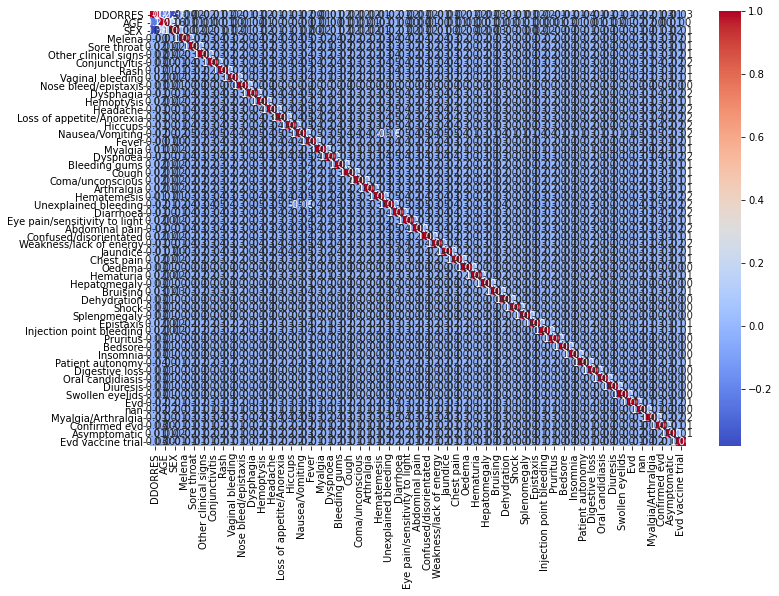

In [126]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 8))
corr = df_triage.corr()
color = plt.get_cmap('coolwarm')
color.set_bad('lightgrey') 
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns ,annot=True, fmt=".2f", cmap = color)
plt.show()

In [124]:

df_triage = df_triage.loc[:, (df_triage != 0).any(axis=0)]

In [121]:
import statsmodels.api as sm

X = sm.add_constant(df_triage.loc[:, df_triage.columns != 'DDORRES'])
y = df_triage['DDORRES']

est_OLS = sm.OLS(y, X.astype(float)).fit()
print(est_OLS.summary())

                            OLS Regression Results                            
Dep. Variable:                DDORRES   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     20.37
Date:                Sat, 14 Nov 2020   Prob (F-statistic):          3.54e-169
Time:                        11:42:26   Log-Likelihood:                -1572.1
No. Observations:                4508   AIC:                             3252.
Df Residuals:                    4454   BIC:                             3599.
Df Model:                          53                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [122]:
est_logit = sm.Logit(y, X.astype(float)).fit()
print(est_logit.summary())

         Current function value: 0.364825
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                DDORRES   No. Observations:                 4508
Model:                          Logit   Df Residuals:                     4454
Method:                           MLE   Df Model:                           53
Date:                Sat, 14 Nov 2020   Pseudo R-squ.:                  0.2202
Time:                        11:42:34   Log-Likelihood:                -1644.6
converged:                      False   LL-Null:                       -2109.1
Covariance Type:            nonrobust   LLR p-value:                2.551e-160
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -5.6952   3.36e+06   -1.7e-06      1.000   -6.58e+06    6.58e+06
AGE     

/home/lavinia/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "
